# 🌻 Practical 2: Flower Classification with Activation Functions
This is **Practical 2** of the **Hands-On Computer Vision Series: A Practical Learning Journey**.

In this notebook, we enhance our neural network model by adding **activation functions**, specifically the **ReLU** activation function. This allows the model to learn non-linear patterns and improves its classification capability.

We also explain **loss functions**, **learning rate**, and important **hyperparameters** you can tune.

In [1]:
# Import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define image size and class names
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

## ☁️ Using Google Cloud-hosted Flower Dataset
This notebook uses flower images and labels stored in **CSV format** on Google Cloud:

- `train_set.csv` for training
- `eval_set.csv` for evaluation

If you are running locally:
- Download the dataset and CSVs
- Replace the paths with your local file paths
- Ensure image paths in the CSV match your local folder structure

In [3]:
# Load dataset from CSV and parse image-label pairs
def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

def parse_csvline(csv_line):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label


In [4]:
# You can change the batch size here to 16, 32, 64, etc.
# Load training and evaluation datasets from Google Cloud
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

## 🔧 What is an Activation Function?
Activation functions are essential in neural networks because they introduce **non-linearity**. Without them, a model made of multiple layers would behave just like a single-layer linear model.

**Why we need them:**
- They allow the network to **learn complex patterns** in the data
- They help us solve problems that are **not linearly separable**
- They add depth to the network’s decision-making ability

### 🚀 Common Activation Functions:
- 🔸 **ReLU (Rectified Linear Unit):**
  - Formula: $f(x) = \max(0, x)$
  - Most widely used due to its simplicity and efficiency
  - Helps avoid vanishing gradients

- 🔸 **Sigmoid:**
  - Formula: $f(x) = \frac{1}{1 + e^{-x}}$
  - Squashes values into the range [0, 1]
  - Commonly used in binary classification (output layer)

- 🔸 **Tanh:**
  - Formula: $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
  - Range: [-1, 1], centered at 0
  - Can work better than sigmoid for hidden layers

- 🔸 **Softmax:**
  - Used in the output layer for **multi-class classification**
  - Converts raw scores into probabilities that sum to 1

➡️ In this notebook, we use **ReLU** for hidden layers and **Softmax** in the output layer.

In [5]:
# Feel free to adjust the number of hidden units (e.g., 64, 256)
# Build the model with activation functions
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(5, activation='softmax')  # Output layer
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,284,869 (73.57 MB)

 Trainable params: 19,284,869 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

## 📉 What is a Loss Function?
A **loss function** tells the model how far off its predictions are from the actual labels. It is a critical part of training, as it drives how the model learns by adjusting weights to minimize this loss.

### 🧪 How it works:
1. The model makes a prediction
2. The loss function compares this prediction to the true label
3. It computes an error (loss)
4. This loss is used to update the model’s weights using backpropagation

### 🔍 Types of Loss Functions:
- 🔹 **SparseCategoricalCrossentropy**:
  - Used when labels are integers (not one-hot encoded)
  - Perfect for multi-class classification (like our flower dataset)

- 🔹 **CategoricalCrossentropy**:
  - Use this when your labels are **one-hot encoded** (e.g., [0, 0, 1, 0, 0])

- 🔹 **BinaryCrossentropy**:
  - Used for binary classification problems (e.g., cat vs. dog)
  - Often paired with a sigmoid activation

- 🔹 **Mean Squared Error (MSE)**:
  - Common in regression tasks

➡️ In this practical, we use **SparseCategoricalCrossentropy** because our dataset contains multiple classes and integer labels.
The goal during training is to minimize this loss as much as possible.

## 🛠️ Understanding Hyperparameters
**Hyperparameters** are external configuration values set before training. They’re not learned from the data, but they directly influence how well your model learns.

### 🔑 Common Hyperparameters:
- **Learning Rate**: Controls how big each weight update step is.
  - Too high → training may diverge
  - Too low → training is slow or stuck
- **Batch Size**: Number of samples processed before weights are updated.
  - Smaller batch size → noisier but more generalized updates
  - Larger batch size → faster training but may overfit
- **Number of Epochs**: How many times the model sees the entire dataset.
  - More epochs → potentially better training (until overfitting begins)
- **Number of Hidden Units**: Controls the capacity of the network to learn patterns.
  - Too few → underfitting
  - Too many → overfitting if regularization isn’t applied
- **Image Size**: Affects the resolution of input data and model complexity

### 🧪 Try This:
- Change `learning_rate=0.001` to `0.0001` or `0.01`
- Try different `batch_size` like `16`, `32`, `64`
- Increase or decrease the number of neurons in hidden layers
- Add more epochs to see performance trends over time

🔁 **By experimenting with these values, you’ll gain a deeper intuition for how neural networks learn!**

In [6]:
# You can experiment with different learning rates here
# Try: 0.0001, 0.001 (default), 0.01
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [7]:
# Try increasing the number of epochs to see if accuracy improves or overfits
# Train the model
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=5
)

Epoch 1/5
    207/Unknown 203s 967ms/step - accuracy: 0.3063 - loss: 10.2874

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.3065 - loss: 10.2634 - val_accuracy: 0.4351 - val_loss: 1.7461
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 195s 765ms/step - accuracy: 0.4322 - loss: 1.5776 - val_accuracy: 0.3514 - val_loss: 1.9896
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 139s 671ms/step - accuracy: 0.4015 - loss: 1.6376 - val_accuracy: 0.4243 - val_loss: 1.4867
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 140s 664ms/step - accuracy: 0.4226 - loss: 1.4266 - val_accuracy: 0.2973 - val_loss: 1.5619
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 105s 485ms/step - accuracy: 0.3831 - loss: 1.4868 - val_accuracy: 0.3514 - val_loss: 1.4581


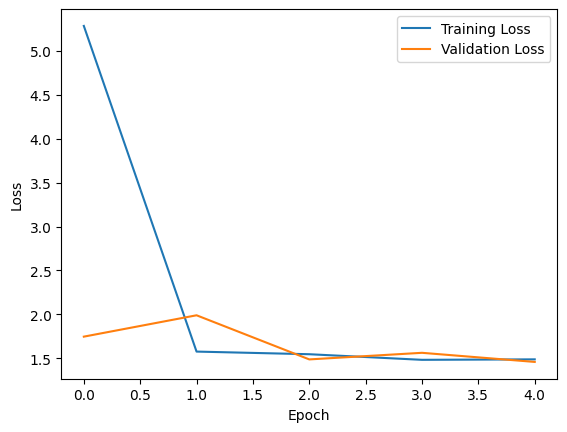

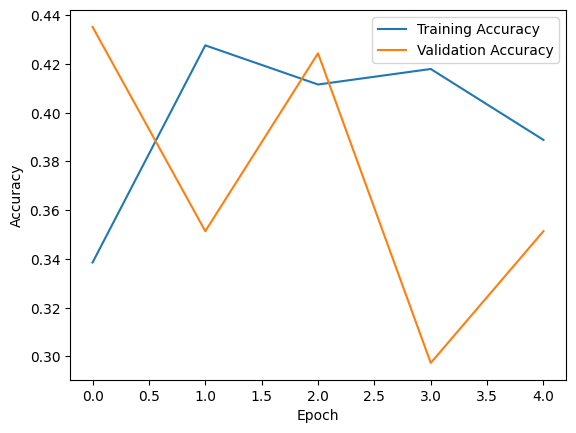

In [9]:
# Plot accuracy and loss curves
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## ✅ Summary: What We Learned
In this practical, you unlocked the power of **non-linear learning** by using activation functions!

- 🧠 **ReLU** enabled the model to learn complex, non-linear patterns from image data.
- 📈 You saw how to build a deeper model with **two hidden layers**.
- 📉 We explained **loss functions** and how models learn by minimizing error.
- 🔧 We introduced **hyperparameters** like learning rate and hidden units—feel free to tweak them!

🎓 By experimenting with different values, you’ll start to see how model behavior changes in real time.

👉 **Up next in Practical 3**:
We’ll tackle **overfitting** and how to fight it using techniques like **Dropout**, **Regularization**, and even deeper networks to build more robust models.

> The journey continues — keep building, keep tweaking, and most of all, keep learning! 🚀